# Image Captioning - generating captions for images




In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# !unzip drive/My\ Drive/flickr-image-dataset

In [0]:
import warnings
warnings.filterwarnings('ignore')

In [0]:
import shutil
import os
import json

In [0]:
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import keras

In [0]:
# shutil.rmtree('flickr30k_images//')

## 1. Data Pipeline

#### 1.0.1 directory stucture for training
flickr30k
  - images
    - train
    - val
  - captions
    - train
    - val

In [0]:
# parent directory
if not os.path.isdir('flickr30k'):
  os.mkdir('flickr30k')

In [0]:
# subdirecotry for images and captions
if not os.path.isdir('flickr30k/images'):
  os.mkdir('flickr30k/images')
if not os.path.isdir('flickr30k/captions'):
  os.mkdir('flickr30k/captions')

In [0]:
# training and validation subdirectories
if not os.path.isdir('flickr30k/images/train'):
  os.mkdir('flickr30k/images/train')
if not os.path.isdir('flickr30k/images/val'):
  os.mkdir('flickr30k/images/val')
if not os.path.isdir('flickr30k/captions/train'):
  os.mkdir('flickr30k/captions/train')
if not os.path.isdir('flickr30k/captions/val'):
  os.mkdir('flickr30k/captions/val')

In [0]:
total_images = len(os.listdir('flickr30k_images/flickr30k_images/'))

In [0]:
# 31K images for training and 783 for validation

In [0]:
captions = pd.read_csv('flickr30k_images/results.csv', sep='delimiter', header=None)

In [14]:
captions.head()

,0
0,image_name| comment_number| comment
1,1000092795.jpg| 0| Two young guys with shaggy ...
2,"1000092795.jpg| 1| Two young , White males are..."
3,1000092795.jpg| 2| Two men in green shirts are...
4,1000092795.jpg| 3| A man in a blue shirt stand...


In [0]:
captions = captions.values[1:]

In [16]:
captions.shape

(158915, 1)

In [17]:
total_images

31783

In [18]:
31783*5

158915

In [19]:
captions[0][0].split('| ')

['1000092795.jpg',
 '0',
 'Two young guys with shaggy hair look at their hands while hanging out in the yard .']

In [0]:
parent_dir = 'flickr30k_images/flickr30k_images/'
val_dir = 'flickr30k/images/val/'
train_dir = 'flickr30k/images/train/'

In [0]:
validation_description = {}

# validation seperation
for val_i in range(0, 783*5, 5):
  
  img_name = ''
  
  # each image has five captions
  for val_j in range(val_i, val_i + 5, 1):
   
    # split the description to get image_name and caption
    desc = captions[val_j][0].split('| ')
    img_name = desc[0] # img_name
    caption = desc[-1] # 0th caption
    
    # enter the empty list initially
    if validation_description.get(img_name) is None:
      validation_description[img_name] = []
      
    validation_description[img_name].append(caption)
  
  
  # move the img_name from here to val dir
  src = os.path.join(parent_dir, img_name)
  des = os.path.join(val_dir, img_name)
  shutil.move(src, des)
  

In [0]:
# write val description into val dir
with open('flickr30k/captions/val/validation_description.json', 'w') as fp:
  json.dump(validation_description, fp)


In [0]:
training_description = {}

# training seperation
for train_i in range(783*5, len(captions), 5):
  
  img_name = ''
  
  # each image has five captions
  for train_j in range(train_i, train_i + 5, 1):
   
    # split the description to get image_name and caption
    desc = captions[train_j][0].split('| ')
    img_name = desc[0] # img_name
    caption = desc[-1] # 0th caption
    
    # enter the empty list initially
    if training_description.get(img_name) is None:
      training_description[img_name] = []
      
    training_description[img_name].append(caption)
  
  
  # move the img_name from here to val dir
  src = os.path.join(parent_dir, img_name)
  des = os.path.join(train_dir, img_name)
  shutil.move(src, des)

In [0]:
# write train description into train dir

with open('flickr30k/captions/train/training_description.json', 'w') as fp:
  json.dump(training_description, fp)

In [25]:
len(os.listdir('flickr30k/images/val/'))

783

In [26]:
len(os.listdir('flickr30k/images/train/'))

31000

In [27]:
len(validation_description)

783

In [28]:
len(training_description)

31000

In [0]:
# !zip -r flickr30k.zip flickr30k

In [0]:
img = cv2.imread('flickr30k/images/val/1001545525.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

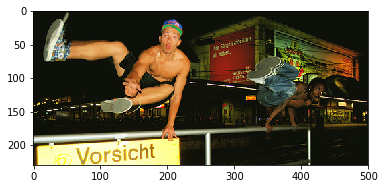

In [38]:
plt.imshow(img);

In [39]:
validation_description['1001545525.jpg']

['Two men in Germany jumping over a rail at the same time without shirts .',
 'Two youths are jumping over a roadside railing , at night .',
 'Boys dancing on poles in the middle of the night .',
 'Two men with no shirts jumping over a rail .',
 'two guys jumping over a gate together']

### 1.1 Text Data (Caption) Cleaning
- No stop word removal
- No stemming
- lower case = upper case
- remove number 
- remove punctuation

In [0]:
import re

In [0]:
with open('flickr30k/captions/train/training_description.json', 'r') as train:
  training_description = json.load(train)
  
with open('flickr30k/captions/val/validation_description.json', 'r') as val:
  validation_description = json.load(val)

In [0]:
t_archive = training_description
v_archive = validation_description 

In [0]:
def clean_text(sentence):
  
  # convert into lower case
  sentence = sentence.lower()
  
  # remove everything except a-z
  sentence = re.sub("[^a-z]+", " ", sentence)
  
  sentence = sentence.split()
  
  #remove single char words ie: a
  sentence = [word for word in sentence if len(word)>1 ]
  
  sentence = " ".join(sentence)
  
  return sentence
  
  

In [0]:
# clean validation description
for img_name, captions in validation_description.items():
  for i in range(len(captions)):
    captions[i] = clean_text(captions[i])
    

In [63]:
for img_name, captions in validation_description.items():
  print(img_name)
  print(captions)
  break

1000092795.jpg
['two young guys with shaggy hair look at their hands while hanging out in the yard', 'two young white males are outside near many bushes', 'two men in green shirts are standing in yard', 'man in blue shirt standing in garden', 'two friends enjoy time spent together']


In [0]:
# cleaning training description
for img_name, captions in training_description.items():
  for i in range(len(captions)):
    captions[i] = clean_text(captions[i])

In [65]:
for img_name, captions in training_description.items():
  print(img_name)
  print(captions)
  break

126227418.jpg
['man in plaid shirt with laptop in his lap is sitting next to table with microscope and circuit board on it', 'man in plaid shirt connecting his black laptop to his microscope', 'guy with laptop connected to microscope doing some research', 'guy hooking up his laptop to microscope', 'man working on circuit board']


In [0]:
# save the clean text in json file
with open('flickr30k/captions/val/clean_val_desc.json', 'w') as fp:
  json.dump(validation_description, fp)
with open('flickr30k/captions/train/clean_train_desc.json', 'w') as fp:
  json.dump(training_description, fp)